In [2]:
!pip install facenet-pytorch
# !pip install cloud-tpu-client==0.10 torch==2.0.0  torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/117/torch_xla-2.0-cp39-cp39-linux_x86_64.whl --force-reinstall
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl (162.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [20]:
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
from torch import optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau, LambdaLR
from torchsummary import summary
import cv2 as cv
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch.nn.functional as F

import random
import shutil
import sys
import multiprocessing

import numpy as np
from PIL import Image

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
from facenet_pytorch import MTCNN
from sklearn.metrics import roc_curve, roc_auc_score

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

"""
Configurations for training and loading the model
"""
import os

from torch import _fake_quantize_learnable_per_tensor_affine

# model parameters
INPUT_SHAPE = (1, 224, 224)
INPUT_SIZE = (224, 224)

# trainging parameters
EPOCHS = 5
BATCH_SIZE = 256
LEARNING_RATE = 0.0006
L2_LAMBDA = 0
WEIGHT_DECAY = 0
LR_DECAY = {'active': True, 'step_size': 1, 'gamma': 0.97}
FINE_TUNE = False
NEW_CHECKPOINTS = True

# EPOCHS = 5
# BATCH_SIZE = 128
# LEARNING_RATE = 0.045
# L2_LAMBDA = 0
# WEIGHT_DECAY = 0
# LR_DECAY = {'active': True, 'step_size': 1, 'gamma': 0.94}
# FINE_TUNE = False
# NEW_CHECKPOINTS = True

# # model parameters
# INPUT_SHAPE = (3, 299, 299)
# INPUT_SIZE = (299, 299)
EMBEDDING_SIZE = 4096
DROPOUT_LOW = 0.2
DROPOUT_MID = 0.2
DROPOUT_HIGH = 0.25

# DATASET_PATH = r''#r'<PATH TO YOUR DATA SET TO TRAIN ON>'
TRAIN_DATASET_PATH = r'/content/drive/My Drive/datasets/LFW/lfw-funneled/lfw_funneled_transformed_train'
TEST_DATASET_PATH = r'/content/drive/My Drive/datasets/LFW/lfw-funneled/lfw_funneled_transformed_test'
# TRAIN_DATASET_PATH = r'/content/drive/My Drive/datasets/lfw+/TRAIN'
# TEST_DATASET_PATH = r'/content/drive/My Drive/datasets/lfw+/TRAIN'

# TRAIN_DATASET_PATH = r'/content/drive/My Drive/datasets/celeb_a_aligned_jpg/subjects_transformed_train'
# TEST_DATASET_PATH = r'/content/drive/My Drive/datasets/celeb_a_aligned_jpg/subjects_transformed_test'

MODEL_NAME = r'model.pth'
MODEL_PATH = os.path.join(os.getcwd(), MODEL_NAME)

OUT_NAME = r'model.pth'
OUT_PATH = os.path.join(os.getcwd(), OUT_NAME)


In [4]:
class ModelDataset(Dataset):
    """
    The dataset class for the model
    """

    def __init__(self, root, transform=None, train_ratio=0.8):
        self.ds_path = root
        self.dataset = datasets.ImageFolder(root=root)
        self.transform = transform
        self.train_ratio = train_ratio

    def __getitem__(self, index):
        """
        Get a dataset pair with a label for training
        :return: image1, image2, label (0 if of same subject, else 1)
        """
        img0_tup = random.choice(self.dataset.imgs)

        pair = random.randint(0, 1)
        if pair:
            while True:
                img1_tup = random.choice(self.dataset.imgs)
                if img0_tup[1] == img1_tup[1]:
                    break
        else:
            while True:
                img1_tup = random.choice(self.dataset.imgs)
                if img0_tup[1] != img1_tup[1]:
                    break

        img0 = Image.open(img0_tup[0])
        img1 = Image.open(img1_tup[0])

        # img0 = img0.convert('L')
        # img1 = img1.convert('L')

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1, torch.from_numpy(np.array([int(img1_tup[1] != img0_tup[1])], dtype=np.float32))

    def __len__(self):
        return len(self.dataset.imgs)

    def __len__(self):
        return len(self.dataset.imgs)

    def split_dataset(self):
        # Compute the number of samples for train/validation split
        num_samples = len(self.dataset)
        num_train = int(self.train_ratio * num_samples)
        num_valid = num_samples - num_train

        # Perform the train/validation split
        train_dataset, valid_dataset = random_split(self, [num_train, num_valid])
        train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=get_workers())
        valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=get_workers())
        return train_loader, valid_loader


    @staticmethod
    def create_image(image, box):
        """
        Create an image in a usable format for the model (preprocess)
        :param image: the original image to cut from
        :param box: face bounding box in format top left bottom right
        :return: the face on white background
        """
        x1, y1, x2, y2 = box

        h, w, _ = image.shape
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w, x2)
        y2 = min(h, y2)

        width = x2 - x1
        height = y2 - y1
        cut = image[y1: y2, x1: x2]
        prop = width / height

        if width > height:
            width = 300
            height = int(300 / prop)
        else:
            width = int(prop * 300)
            height = 300
        cut = cv.resize(cut, (width, height))

        canvas = np.ones((300, 300, 3), dtype=np.uint8) * 255
        start_x = (300 - width) // 2
        start_y = (300 - height) // 2
        canvas[start_y: start_y + height, start_x: start_x + width] = cut

        canvas = cv.cvtColor(canvas, cv.COLOR_BGR2GRAY)
        return canvas

    @staticmethod
    def create_samples_from_folders(parent=r'C:\LockMe_DATA\temp', start=0):
        """
        Create a basic dataset from folders of images in form of the AT&T dataset
        :param parent: the parent directory of all subjects
        """
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        mtcnn = MTCNN(
            image_size=160, margin=0, min_face_size=20,
            thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
            device=device
        )
        os.mkdir(r'C:\LockMe_DATA\temp_tag')
        people = os.listdir(parent)
        index = start + 1
        for i, p in enumerate(people):
            new_dir = os.path.join(r'C:\LockMe_DATA\temp_tag', f's{index}')
            os.makedirs(new_dir)
            valid = True
            for j, file in enumerate(os.listdir(os.path.join(parent, p))):
                image = cv.imread(os.path.join(parent, p, file))
                boxes, conf = mtcnn.detect(image)
                if boxes is None or len(boxes) != 1:
                    print(f'oops, get another image for {os.path.join(parent, p, file)}!')
                    valid = False
                    break
                boxes = boxes.astype(int)
                boxes = [box for i, box in enumerate(boxes)]
                frame = ModelDataset.create_image(image, boxes[0])
                cv.imwrite(os.path.join(new_dir, f'{j + 1}.pgm'), frame)
            if not valid:
                shutil.rmtree(new_dir)
            else:
                index += 1

    @staticmethod
    def filter_ds(path_to_lfw, new_base_path, lower=1, upper=sys.maxsize):
        """
        Filter the LFW database for subjects with more images that the threshold
        :param path_to_lfw: the path to the current LFW folder
        :param new_base_path: path to the filtered dataset
        :param lower: the minimum amount of samples
        :param upper: the maximum amount of samples
        """
        folders = os.listdir(path_to_lfw)
        for folder in folders:
            dir_path = os.path.join(path_to_lfw, folder)
            if lower <= len(os.listdir(dir_path)) <= upper:
                os.mkdir(os.path.join(new_base_path, folder))
                for file in os.listdir(dir_path):
                    old_path = os.path.join(dir_path, file)
                    new_path = os.path.join(new_base_path, folder, file)
                    shutil.copy(old_path, new_path)

    @staticmethod
    def filter_faces(path):
        """
        Remove all images which not contain 1 face exactly
        :param path: path to the dataset parent folder
        """
        folders = [os.path.join(path, directory) for directory in os.listdir(path) if
                   os.path.isdir(os.path.join(path, directory))]
        files = []
        for folder in folders:
            for file in os.listdir(folder):
                files.append(os.path.join(folder, file))
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        mtcnn = MTCNN(
            image_size=160, margin=0, min_face_size=20,
            thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
            device=device
        )

        for file in files:
            image = cv.imread(file)
            boxes, conf = mtcnn.detect(image)
            if boxes is None or len(boxes) != 1:
                print(file)
                os.remove(file)

    def cam_face_generation(self, path=None):
        """
        Generate face from the camera
        """

        if path is None:
            folders = [file for file in os.listdir(self.ds_path) if os.path.isdir(os.path.join(self.ds_path, file))]
            new_path = os.path.join(self.ds_path, f's{len(folders) + 1}')
            if not os.path.exists(new_path):
                os.mkdir(new_path)
        else:
            new_path = path

        cap = cv.VideoCapture(0)
        cntr = 0
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        mtcnn = MTCNN(
            image_size=160, margin=0, min_face_size=20,
            thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
            device=device
        )

        while True:
            ret, frame = cap.read()
            frame = frame[150:350, 150:350]

            frame = cv.resize(frame, (500, 500))
            frame = cv.flip(frame, 1)
            cv.imshow('cam', frame)

            key = cv.waitKey(1)
            if key == ord('c'):
                boxes, conf = mtcnn.detect(frame)
                boxes = boxes.astype(int)
                boxes = [box for i, box in enumerate(boxes) if conf[i] >= 0.95]

                frame = ModelDataset.create_image(frame, boxes[0])

                cntr += 1
                cv.imwrite(f'{os.path.join(new_path, f"{cntr}")}.pgm', frame)
                print(f'image saved - {cntr} images saved until now')
            elif key == ord('q'):
                break

        for image_path in [os.path.join(new_path, filename) for filename in os.listdir(new_path)]:
            image = cv.imread(image_path)
            plt.axis('off')
            plt.imshow(image)
            plt.show()
            print(image_path)

    def augment_dataset(self, new_ds_path, discover=True):
        """
        Transfer the current dataset to another folder and augment the images
        :param new_ds_path: path to the new dataset folder
        :param discover: discover faces from raw images
        """
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        mtcnn = MTCNN(
            image_size=160, margin=0, min_face_size=20,
            thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
            device=device
        )
        cntr = 0

        folders = [name for name in os.listdir(self.ds_path) if os.path.isdir(os.path.join(self.ds_path, name))]
        for folder in folders:
            if not os.path.exists(os.path.join(new_ds_path, folder)):
                os.makedirs(os.path.join(new_ds_path, folder))
            for i in range(1, len(os.listdir(os.path.join(self.ds_path, folder))) + 1):
                length = len(os.listdir(os.path.join(self.ds_path, folder)))
                old_path = os.path.join(self.ds_path, folder, f'{i}.pgm')
                new_path = os.path.join(new_ds_path, folder, f'{i}.pgm')
                new_path_bright = os.path.join(new_ds_path, folder, f'{i + length}.pgm')
                new_path_dark = os.path.join(new_ds_path, folder, f'{i + 2 * length}.pgm')
                new_path_flip = os.path.join(new_ds_path, folder, f'{i + 3 * length}.pgm')

                frame = cv.imread(old_path, cv.IMREAD_GRAYSCALE)
                if discover:
                    frame = cv.cvtColor(frame, cv.COLOR_GRAY2BGR)

                    frame = cv.resize(frame, (500, 500))
                    boxes, conf = mtcnn.detect(frame)
                    boxes = boxes.astype(int)
                    boxes = [box for i, box in enumerate(boxes) if conf[i] >= 0.95]

                darkened = cv.convertScaleAbs(frame, alpha=1.1, beta=0)
                brightened = cv.convertScaleAbs(frame, alpha=0.7, beta=0)

                if discover:
                    frame = ModelDataset.create_image(frame, boxes[0])
                    darkened = ModelDataset.create_image(darkened, boxes[0])
                    brightened = ModelDataset.create_image(brightened, boxes[0])
                flipped = cv.flip(frame, 1)
                try:
                    cntr += 1
                    cv.imwrite(new_path, frame)
                    cv.imwrite(new_path_dark, darkened)
                    cv.imwrite(new_path_bright, brightened)
                    cv.imwrite(new_path_flip, flipped)
                except:
                    print(f'error in writing files: {new_path} or the others')
                print(f'image saved - {cntr} images saved until now')



In [5]:
def imshow(img, text=None):
    """
    Plot image with text
    :param img: the image to plot
    :param text: add text to the image
    """
    img = img.numpy()
    # img += 0.5
    img *= 255.
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()


def get_workers():
    """
    Get suitable number of CPUs for training the model
    :return: number of CPUs
    """
    num_workers = multiprocessing.cpu_count()
    if num_workers > 2:
        num_workers -= 2
    return num_workers


In [6]:
"""
The Siamese Neural Network (SNN) model
"""


class Net(nn.Module):
    embedding_size = EMBEDDING_SIZE

    def __init__(self, cnn_type='classic'):
        super(Net, self).__init__()
        # conv block structure:
        # input: 105 x 105 (1 depth)\
        # 2D convolution -> batch normalization -> ReLU activation -> max-pooling (2D) -> drop-out
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, 10),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(DROPOUT_HIGH)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 7),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(DROPOUT_HIGH)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 128, 4),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(DROPOUT_MID)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, 4),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_MID)
        )

        self.conv_block5 = nn.Sequential(
            nn.Conv2d(256, 512, 4, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_LOW)
        )

        # Calculate the output size of the conv layers
        self.conv_output_size = self._get_conv_output_size()

        self.fc = nn.Sequential(
            nn.Linear(self.conv_output_size, Net.embedding_size),
            # nn.Dropout(DROPOUT_LOW, inplace=True),
            # nn.Linear(4096, Net.embedding_size),
            nn.Sigmoid()
        )

        self.fcOut = nn.Linear(Net.embedding_size, 1)
        self.sigmoid = nn.Sigmoid()

    def _get_conv_output_size(self):
        x = self.conv_block1(torch.zeros(1, 1, INPUT_SIZE[0], INPUT_SIZE[1]))
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        # x = self.conv_block5(x)
        return x.view(x.size(0), -1).size(1)

    def forward_once(self, x):
        """
        Forward propagation through the convolutional part of the SNN
        :param x: the transformed image
        :return: embedding of the transformed image
        """
        # INPUT: 1 ,  105 x 105
        x = self.conv_block1(x)     # 64,  48  x 48
        x = self.conv_block2(x)     # 128, 21  x 21
        x = self.conv_block3(x)     # 128, 9   x 9
        x = self.conv_block4(x)     # 256, 6   x 6
        # x = self.conv_block5(x)     # 512, 6   x 6
        x = x.view(-1, self.conv_output_size)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        """
        Forward propagation through the SNN
        This function is automatically called
        :param x1: first transformed image
        :param x2: second transformed image
        :return: the prediction of the network
        """
        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)

        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

    def forward_embeddings(self, x1, x2):
        """
        Run the SNN model on two image embeddings
        :param x1: first face embedding
        :param x2: second face embedding
        :return: the prediction of the network
        """
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

    @staticmethod
    def preprocess_image(image):
        """
        Preprocess the image before inserting it to the network
        :param image: the sample
        :return: the new image in the model's format
        """
        image = Image.fromarray(cv.cvtColor(image, cv.COLOR_BGR2GRAY)).convert('L')

        transform = transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor()
        ])

        image = transform(image)
        return image


In [7]:
class BasicConv2d(nn.Module):
    """
    Basic convolution definition for the inception-resnet-v2 model
    """

    def __init__(self, in_channels, out_channels, activation='relu', **kwargs):
        """
        Constractor for the basic convolution layer
        :param in_channels: the number of input channels to the layer
        :param out_channels: the number of output channels of the layer
        :param activation: the activation layer after the convolution
        """
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.activation = activation
        self.linear = nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)

        if self.activation == 'relu':
            x = F.relu(x)
        elif self.activation == 'linear':
            x = self.linear(x)
        return x


class Lambda(nn.Module):
    """
    Representation of a lambda layer
    """

    def __init__(self, lam):
        super(Lambda, self).__init__()
        self.lam = lam

    def forward(self, x):
        return self.lam(x)


class InceptionResNetA(nn.Module):
    """
    Representation of the Inception-resnet-v2 Convolution block A
    """

    def __init__(self, in_channels, scale=True):
        super(InceptionResNetA, self).__init__()

        self.branch_a = BasicConv2d(in_channels, 32, kernel_size=1, padding='same')
        self.branch_b = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=1, padding='same'),
            BasicConv2d(32, 32, kernel_size=3, padding='same'),
        )

        self.branch_c = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=1, padding='same'),
            BasicConv2d(32, 48, kernel_size=3, padding='same'),
            BasicConv2d(48, 64, kernel_size=3, padding='same')
        )
        self.concat_branch1x1 = BasicConv2d(128, 384, kernel_size=1, padding='same', activation='linear')
        self.scale = scale
        self.scale_res = Lambda(lambda x: x * 0.1)
        self.bn = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        branch_a = self.branch_a(x)
        branch_b = self.branch_b(x)
        branch_c = self.branch_c(x)

        outputs = [branch_a, branch_b, branch_c]
        mixed = torch.cat(outputs, 1)   # concatenation of the a, b, c branches

        mixed = self.concat_branch1x1(mixed)    # convolution on the concatenated branch
        if self.scale:
            mixed = self.scale_res(mixed)   # scale down the mixed branches impact
        x = x.add(mixed)
        x = F.relu(self.bn(x))
        return x


class InceptionResNetB(nn.Module):
    """
    Representation of the Inception-resnet-v2 Convolution block B
    """

    def __init__(self, in_channels, scale=True):
        super(InceptionResNetB, self).__init__()

        self.branch_a = BasicConv2d(in_channels, 192, kernel_size=1, padding='same')
        self.branch_b = nn.Sequential(
            BasicConv2d(in_channels, 128, kernel_size=1, padding='same'),
            BasicConv2d(128, 160, kernel_size=(1, 7), padding='same'),
            BasicConv2d(160, 192, kernel_size=(7, 1), padding='same')
        )
        self.concat_branch1x1 = BasicConv2d(384, 1152, kernel_size=1, padding='same', activation='linear')
        self.scale = scale
        self.scale_res = Lambda(lambda x: x * 0.1)
        self.bn = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        branch_a = self.branch_a(x)
        branch_b = self.branch_b(x)

        outputs = [branch_a, branch_b]
        mixed = torch.cat(outputs, 1)   # concatenation of the a and b branches

        mixed = self.concat_branch1x1(mixed)    # convolution on the concatenated branch
        if self.scale:
            mixed = self.scale_res(mixed)   # scale down the mixed branches impact
        x = x.add(mixed)
        x = F.relu(self.bn(x))
        return x


class InceptionResNetC(nn.Module):
    """
    Representation of the Inception-resnet-v2 Convolution block C
    """

    def __init__(self, in_channels, scale=True):
        super(InceptionResNetC, self).__init__()

        self.branch_a = BasicConv2d(in_channels, 192, kernel_size=1, padding='same')
        self.branch_b = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1, padding='same'),
            BasicConv2d(192, 224, kernel_size=(1, 3), padding='same'),
            BasicConv2d(224, 256, kernel_size=(3, 1), padding='same')
        )
        self.concat_branch1x1 = BasicConv2d(448, 2144, kernel_size=1, padding='same', activation='linear')
        self.scale = scale
        self.scale_res = Lambda(lambda x: x * 0.1)
        self.bn = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        branch_a = self.branch_a(x)
        branch_b = self.branch_b(x)
        outputs = [branch_a, branch_b]
        mixed = torch.cat(outputs, 1)   # concatenation of the a and b branches

        mixed = self.concat_branch1x1(mixed)    # convolution on the concatenated branch
        if self.scale:
            mixed = self.scale_res(mixed)   # scale down the mixed branches impact
        x = x.add(mixed)
        x = F.relu(self.bn(x))
        return x


class ReductionA(nn.Module):
    """
    Representation of the Inception-resnet-v2 reduction block A
    """

    def __init__(self, in_channels, out_channels):
        super(ReductionA, self).__init__()

        self.branch_a = nn.MaxPool2d(kernel_size=3, stride=2)
        self.branch_b = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)
        self.branch_c = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1, padding='same'),
            BasicConv2d(256, 256, kernel_size=3, padding='same'),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        branch_a = self.branch_a(x)
        branch_b = self.branch_b(x)
        branch_c = self.branch_c(x)

        outputs = [branch_a, branch_b, branch_c]
        x = torch.cat(outputs, 1)   # concatenation of the a, b, c branches
        x = F.relu(self.bn(x))
        return x


class ReductionB(nn.Module):
    """
    Representation of the Inception-resnet-v2 reduction block B
    """

    def __init__(self, in_channels, out_channels):
        super(ReductionB, self).__init__()

        self.branch_a = nn.MaxPool2d(kernel_size=3, stride=2)
        self.branch_b = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1, padding='same'),
            BasicConv2d(256, 384, kernel_size=3, stride=2),
        )

        self.branch_c = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1, padding='same'),
            BasicConv2d(256, 288, kernel_size=3, stride=2)
        )

        self.branch_d = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1, padding='same'),
            BasicConv2d(256, 288, kernel_size=3, padding='same'),
            BasicConv2d(288, 320, kernel_size=3, stride=2),
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        branch_a = self.branch_a(x)
        branch_b = self.branch_b(x)
        branch_c = self.branch_c(x)
        branch_d = self.branch_d(x)

        x = torch.cat([branch_a, branch_b, branch_c, branch_d], 1)  # concatenation of the a, b, c branches
        x = F.relu(self.bn(x))
        return x


class Stem(nn.Module):
    """
    The Stem block of the inception-resnet-v2 block
    """

    def __init__(self):
        super(Stem, self).__init__()
        # pre
        self.conv1 = BasicConv2d(3, 32, kernel_size=3, stride=2, padding='valid')
        self.conv2 = BasicConv2d(32, 32, kernel_size=3, stride=1, padding='valid')
        self.conv3 = BasicConv2d(32, 64, kernel_size=3, stride=1, padding='same')

        # block 1
        self.b1_branch_a = BasicConv2d(64, 96, kernel_size=3, stride=2, padding='valid')
        self.b1_branch_b = nn.MaxPool2d(kernel_size=3, stride=2)

        # block 2
        self.b2_branch_a = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1, padding='same'),
            BasicConv2d(64, 64, kernel_size=(7, 1), stride=1, padding='same'),
            BasicConv2d(64, 64, kernel_size=(1, 7), stride=1, padding='same'),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding='valid')
        )

        self.b2_branch_b = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1, padding='same'),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding='valid')
        )

        # block 3
        self.b3_branch_a = nn.MaxPool2d(kernel_size=3, stride=2)
        self.b3_branch_b = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        branch_a = self.b1_branch_a(x)
        branch_b = self.b1_branch_b(x)

        mixed = torch.cat((branch_a, branch_b), dim=1)  # concatenate branches a and b

        branch_a = self.b2_branch_a(mixed)
        branch_b = self.b2_branch_b(mixed)

        mixed = torch.cat((branch_a, branch_b), dim=1)  # concatenate branches a and b

        branch_a = self.b3_branch_a(mixed)
        branch_b = self.b3_branch_b(mixed)
        mixed = torch.cat((branch_a, branch_b), dim=1)  # concatenate branches a and b
        return mixed


class InceptionResNetV2(nn.Module):
    """
    Representation of the inception-resnet-v2 network
    """

    def __init__(self, num_classes=1000, training=True, scale=True):
        super(InceptionResNetV2, self).__init__()

        self.scale = scale

        # Stem
        self.stem = Stem()

        # Inception-ResNet-A blocks
        self.inception_resnet_a1 = InceptionResNetA(384, self.scale)
        self.inception_resnet_a2 = InceptionResNetA(384, self.scale)
        self.inception_resnet_a3 = InceptionResNetA(384, self.scale)
        self.inception_resnet_a4 = InceptionResNetA(384, self.scale)
        self.inception_resnet_a5 = InceptionResNetA(384, self.scale)

        # Reduction-A
        self.reduction_a = ReductionA(384, 1152)

        # Inception-ResNet-B blocks
        self.inception_resnet_b1 = InceptionResNetB(1152, self.scale)
        self.inception_resnet_b2 = InceptionResNetB(1152, self.scale)
        self.inception_resnet_b3 = InceptionResNetB(1152, self.scale)
        self.inception_resnet_b4 = InceptionResNetB(1152, self.scale)
        self.inception_resnet_b5 = InceptionResNetB(1152, self.scale)
        self.inception_resnet_b6 = InceptionResNetB(1152, self.scale)
        self.inception_resnet_b7 = InceptionResNetB(1152, self.scale)
        self.inception_resnet_b8 = InceptionResNetB(1152, self.scale)
        self.inception_resnet_b9 = InceptionResNetB(1152, self.scale)
        self.inception_resnet_b10 = InceptionResNetB(1152, self.scale)

        # Reduction-B
        self.reduction_b = ReductionB(1152, 2144)

        # Inception-ResNet-C blocks
        self.inception_resnet_c1 = InceptionResNetC(2144, self.scale)
        self.inception_resnet_c2 = InceptionResNetC(2144, self.scale)
        self.inception_resnet_c3 = InceptionResNetC(2144, self.scale)
        self.inception_resnet_c4 = InceptionResNetC(2144, self.scale)
        self.inception_resnet_c5 = InceptionResNetC(2144, self.scale)

        # Average pooling and linear layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2144, num_classes)

        self.training = training

    def forward(self, x):
        # Stem
        x = self.stem(x)

        # Inception-ResNet-A blocks
        x = self.inception_resnet_a1(x)
        x = self.inception_resnet_a2(x)
        x = self.inception_resnet_a3(x)
        x = self.inception_resnet_a4(x)
        x = self.inception_resnet_a5(x)

        # Reduction-A
        x = self.reduction_a(x)

        # Inception-ResNet-B blocks
        x = self.inception_resnet_b1(x)
        x = self.inception_resnet_b2(x)
        x = self.inception_resnet_b3(x)
        x = self.inception_resnet_b4(x)
        x = self.inception_resnet_b5(x)
        x = self.inception_resnet_b6(x)
        x = self.inception_resnet_b7(x)
        x = self.inception_resnet_b8(x)
        x = self.inception_resnet_b9(x)
        x = self.inception_resnet_b10(x)

        # Reduction-B
        x = self.reduction_b(x)

        # Inception-ResNet-C blocks
        x = self.inception_resnet_c1(x)
        x = self.inception_resnet_c2(x)
        x = self.inception_resnet_c3(x)
        x = self.inception_resnet_c4(x)
        x = self.inception_resnet_c5(x)

        # Average pooling and linear layer
        x = self.avg_pool(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [8]:
class Net2(nn.Module):
    embedding_size = EMBEDDING_SIZE

    def __init__(self):
        super(Net2, self).__init__()
        self.cnn = InceptionResNetV2(num_classes=Net2.embedding_size)

        self.fcOut = nn.Linear(Net2.embedding_size, 1)
        self.sigmoid = nn.Sigmoid()
        # self.fcOut = nn.Sequential(
        #     nn.Linear(Net2.embedding_size, Net2.embedding_size + 500),
        #     nn.ReLU(),
        #     nn.Linear(Net2.embedding_size, 1)
        # )


    def forward(self, x1, x2):
        """
        Forward propagation through the SNN
        This function is automatically called
        :param x1: first transformed image
        :param x2: second transformed image
        :return: the prediction of the network
        """
        x1 = self.cnn(x1)
        x2 = self.cnn(x2)
        x1 = self.sigmoid(x1)
        x2 = self.sigmoid(x2)

        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

In [37]:
class Net3(nn.Module):
    embedding_size = EMBEDDING_SIZE

    def __init__(self):
        super(Net3, self).__init__()

        def create_conv_block(in_channels, out_channels, size, padding):
          return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
          )

        self.conv11 = create_conv_block(1, 64, 3, 'same')
        self.conv12 = create_conv_block(64, 64, 3, 'valid')

        self.conv21 = create_conv_block(64, 128, 3, 'same')
        self.conv22 = create_conv_block(128, 128, 3, 'valid')

        self.conv31 = create_conv_block(128, 256, 3, 'same')
        self.conv32 = create_conv_block(256, 256, 3, 'same')
        self.conv33 = create_conv_block(256, 256, 3, 'same')
        self.conv34 = create_conv_block(256, 256, 3, 'valid')

        self.conv41 = create_conv_block(256, 512, 3, 'same')
        self.conv42 = create_conv_block(512, 512, 3, 'same')
        self.conv43 = create_conv_block(512, 512, 3, 'same')
        self.conv44 = create_conv_block(512, 512, 3, 'valid')

        self.conv51 = create_conv_block(512, 512, 3, 'same')
        self.conv52 = create_conv_block(512, 512, 3, 'same')
        self.conv53 = create_conv_block(512, 512, 3, 'same')
        self.conv54 = create_conv_block(512, 512, 3, 'valid')

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = lambda d: nn.Dropout(d)
        self.batch_norm = lambda c: nn.BatchNorm2d(c)

        self.fc1 = nn.Linear(self._get_conv_output_size(), 4096)
        self.fc2 = nn.Linear(4096, Net3.embedding_size)
        self.fcOut = nn.Linear(Net3.embedding_size, 1)
        self.sigmoid = nn.Sigmoid()

    def _get_conv_output_size(self):
        x = torch.zeros(1, 1, INPUT_SIZE[0], INPUT_SIZE[1])
        x = self.convs(x)
        return x.view(x.size(0), -1).size(1)

    def convs(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool(x)
        x = self.batch_norm(64)(x)
        x = self.dropout(DROPOUT_HIGH)(x)

        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.pool(x)
        x = self.batch_norm(128)(x)
        x = self.dropout(DROPOUT_HIGH)(x)

        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        # x = F.relu(self.conv33(x))
        x = F.relu(self.conv34(x))
        x = self.pool(x)
        x = self.batch_norm(256)(x)
        x = self.dropout(DROPOUT_HIGH)(x)

        x = F.relu(self.conv41(x))
        x = F.relu(self.conv42(x))
        # x = F.relu(self.conv43(x))
        x = F.relu(self.conv44(x))
        x = self.pool(x)
        x = self.batch_norm(512)(x)
        x = self.dropout(DROPOUT_HIGH)(x)

        x = F.relu(self.conv51(x))
        x = F.relu(self.conv52(x))
        # x = F.relu(self.conv53(x))
        x = F.relu(self.conv54(x))
        x = self.pool(x)
        x = self.batch_norm(512)(x)
        x = self.dropout(DROPOUT_HIGH)(x)
        return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.view(-1, self._get_conv_output_size())
        x1 = self.fc1(x1)
        x1 = self.sigmoid(self.fc2(x1))

        x2 = self.convs(x2)
        x2 = x2.view(-1, self._get_conv_output_size())
        x2 = self.fc1(x2)
        x2 = self.sigmoid(self.fc2(x2))

        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

In [9]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.norm(anchor - positive, p=2, dim=1)
        distance_negative = torch.norm(anchor - negative, p=2, dim=1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(losses), distance_positive, distance_negative

The training function:

In [10]:
def train(net, device, train_loader: DataLoader, valid_loader: DataLoader,
          optimizer: optim, scheduler, criterion, epochs: int, checkpoint_interval: int = 5):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"""Hyper parameters:
    Learning rate: {LEARNING_RATE}
    LR decay: {LR_DECAY}
    Batch-size: {BATCH_SIZE}
    Epochs: {EPOCHS}
    EMBEDDING_SIZE {EMBEDDING_SIZE}
    L2_LAMBDA: {L2_LAMBDA}
    WEIGHT_DECAY: {WEIGHT_DECAY}
    """)
    net.to(device)

    train_losses = []
    valid_losses = []
    train_f1_scores = []
    valid_f1_scores = []
    train_precisions = []
    valid_precisions = []
    train_recalls = []
    valid_recalls = []
    train_accuracies = []
    valid_accuracies = []
    train_roc_auc = []
    valid_roc_auc = []
    suffix = 0

    pos_dist_vals = []
    neg_dist_vals = []

    # warmup_epochs = 5
    # warmup_factor = 0.1
    # warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_factor if epoch < warmup_epochs else 1.0)
    # paleau_scedualer = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    if not os.path.exists('checkpoints'):
        os.mkdir('checkpoints')
    for model in [file for file in os.listdir('checkpoints') if os.path.isfile(os.path.join(os.getcwd(), 'checkpoints', file))]:
        if int(model.split('_')[-1].split('.')[0]) > suffix:
            suffix = int(model.split('_')[-1].split('.')[0])
    print('=== Training started ===')
    for epoch in range(epochs):
        torch.cuda.empty_cache()
        net.train()
        train_loss = 0.0
        train_true_positives = 0
        train_true_negatives = 0
        train_false_positives = 0
        train_false_negatives = 0
        train_correct = 0
        total_train = 0
        print('---running on train---')
        for i, (img0, img1, labels) in enumerate(train_loader, 0):
            img0, img1, labels = img0.to(device), img1.to(device), labels.to(device)

            optimizer.zero_grad()
            outs = net(img0, img1)
            predicted_labels = (outs >= 0.5).long()

            loss = criterion(outs.squeeze(), labels.view(-1, 1).float().squeeze())
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()    # Update the learning rate

            train_correct += (predicted_labels.squeeze() == labels.squeeze()).sum().item()
            total_train += labels.size(0)
            # # Add L2 regularization to the loss
            # l2_loss = 0.0
            # for param in net.parameters():
            #     l2_loss += torch.norm(param, p=2)  # L2 norm of the parameters

            # loss += L2_LAMBDA * l2_loss

            true_positives = torch.sum(predicted_labels * labels).item()
            false_positives = torch.sum(predicted_labels * (1 - labels)).item()
            false_negatives = torch.sum((1 - predicted_labels) * labels).item()
            true_negatives = len(labels) - true_positives - false_positives - false_negatives
            accuracy = (true_positives + true_negatives) / len(labels)

            train_true_positives += true_positives
            train_true_negatives += true_negatives
            train_false_positives += false_positives
            train_false_negatives += false_negatives

            train_loss += loss.item()

            if i % 5 == 0:
                train_accuracy = 100.0 * accuracy
                print(f'\tcurrent loss: {loss.item()}, current accuracy: {train_accuracy}')

        train_loss /= len(train_loader)
        train_precision = train_true_positives / (train_true_positives + train_false_positives)
        train_recall = train_true_positives / (train_true_positives + train_false_negatives)
        train_f1_score = 2 * (train_precision * train_recall) / (train_precision + train_recall)
        train_accuracy = (train_true_positives + train_true_negatives) / len(train_loader.dataset)

        net.eval()
        valid_loss = 0.0
        valid_true_positives = 0
        valid_true_negatives = 0
        valid_false_positives = 0
        valid_false_negatives = 0
        valid_labels = []
        valid_predictions = []
        valid_correct = 0
        total_valid = 0
        with torch.no_grad():
            print('---running on validation---')
            for i, (img0, img1, labels) in enumerate(valid_loader):
                img0, img1, labels = img0.to(device), img1.to(device), labels.to(device)

                outs = net(img0, img1)
                predicted_labels = (outs >= 0.5).long()

                loss = criterion(outs.squeeze(), labels.view(-1, 1).float().squeeze())
                valid_correct += (predicted_labels.squeeze() == labels.squeeze()).sum().item()
                total_valid += labels.size(0)

                true_positives = torch.sum(predicted_labels * labels).item()
                false_positives = torch.sum(predicted_labels * (1 - labels)).item()
                false_negatives = torch.sum((1 - predicted_labels) * labels).item()
                true_negatives = len(labels) - true_positives - false_positives - false_negatives
                accuracy = (true_positives + true_negatives) / len(labels)

                valid_true_positives += true_positives
                valid_true_negatives += true_negatives
                valid_false_positives += false_positives
                valid_false_negatives += false_negatives

                valid_loss += loss.item()

                if i % 10 == 0:
                    valid_accuracy = 100.0 * accuracy
                    print(f'\tcurrent loss: {loss.item()}, current accuracy: {valid_accuracy}')

                # labels = torch.tensor([abs(label - 1.) for label in labels.squeeze()]).to(device)

        valid_loss /= len(valid_loader)
        valid_precision = valid_true_positives / (valid_true_positives + valid_false_positives)
        valid_recall = valid_true_positives / (valid_true_positives + valid_false_negatives)
        valid_f1_score = 2 * (valid_precision * valid_recall) / (valid_precision + valid_recall)
        valid_accuracy = (valid_true_positives + valid_true_negatives) / len(valid_loader.dataset)

        print(f'metrics [{epochs}/{i+1}]: validaion: loss {valid_loss:.3f}, accuracy {valid_accuracy:.3f}, train: loss {train_loss:.3f}, accuracy {train_accuracy:.3f}')

        # Save checkpoint
        if (epoch + 1) % checkpoint_interval == 0:

            if NEW_CHECKPOINTS:
              checkpoint_path = f'/content/checkpoints/checkpoint_epoch_{epoch + 1}.pth'
              torch.save(net.state_dict(), checkpoint_path)
              print(f'Saved checkpoint at epoch {epoch + 1}: {checkpoint_path}')
            else:
              checkpoint_path = f'/content/checkpoints/checkpoint_epoch_{epoch + suffix + 1}.pth'
              torch.save(net.state_dict(), checkpoint_path)
              print(f'Saved checkpoint at epoch {epoch + suffix + 1}: {checkpoint_path}')

        # Append the values for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_f1_scores.append(train_f1_score)
        valid_f1_scores.append(valid_f1_score)
        train_precisions.append(train_precision)
        valid_precisions.append(valid_precision)
        train_recalls.append(train_recall)
        valid_recalls.append(valid_recall)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

    torch.save(net.state_dict(), OUT_PATH)

    # Plotting the results
    plt.figure(figsize=(12, 20))

    # Plot training and validation loss
    plt.subplot(5, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train')
    plt.plot(range(1, epochs + 1), valid_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation F1 score
    plt.subplot(5, 2, 2)
    plt.plot(range(1, epochs + 1), train_f1_scores, label='Train')
    plt.plot(range(1, epochs + 1), valid_f1_scores, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    # Plot training and validation precision
    plt.subplot(5, 2, 3)
    plt.plot(range(1, epochs + 1), train_precisions, label='Train')
    plt.plot(range(1, epochs + 1), valid_precisions, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()

    # Plot training and validation recall
    plt.subplot(5, 2, 4)
    plt.plot(range(1, epochs + 1), train_recalls, label='Train')
    plt.plot(range(1, epochs + 1), valid_recalls, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(5, 2, 5)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training and validation ROC AUC
    # plt.subplot(5, 2, 6)
    # plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    # plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random prediction
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic (ROC) Curve')
    # plt.legend()

    # plt.subplot(5, 2, 6)
    # graph = sorted(zip(pos_dist_vals, neg_dist_vals), key=lambda x: x[0])
    # x = [val[0].cpu() for val in graph]
    # y = [val[1].cpu() for val in graph]
    # conditions = [x < y for x, y in zip(x, y)]
    # colors = ['green' if condition else 'red' for condition in conditions]
    # plt.scatter(x, y, c=colors, alpha=0.6)
    # plt.xlabel('+ distance from anchor')
    # plt.ylabel('- distance from anchor')
    # plt.title(f'Positive and negative samples distance from anchor')
    # plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def l2_regularization_loss(model, lambda_reg):
    reg_loss = 0.0
    for param in model.parameters():
        reg_loss += torch.norm(param, p=2) ** 2
    reg_loss *= lambda_reg
    return reg_loss

def train_last(net, train_loader: DataLoader, valid_loader: DataLoader,
          optimizer: optim, scheduler, criterion, epochs: int, checkpoint_interval: int = 2):
    """
    Train the network
    :param net: the network to train
    :param train_loader: training images loader
    :param valid_loader: validation images loader
    :param optimizer: the chosen optimizer for training
    :param scheduler: learning rate scheduler
    :param criterion: the loss function
    :param epochs: number of epochs to train
    :param checkpoint_interval: number of epochs between checkpoints
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    suffix = 0

    if not os.path.exists(os.path.join(os.getcwd(), 'checkpoints')):
        os.mkdir(os.path.join(os.getcwd(), 'checkpoints'))
    for model in [file for file in os.listdir('checkpoints') if os.path.isfile(os.path.join(os.getcwd(), 'checkpoints', file))]:
        if int(model.split('_')[-1].split('.')[0]) > suffix:
            suffix = int(model.split('_')[-1].split('.')[0])
    print('=== Training started ===')
    for epoch in range(epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        print('---running on train---')
        for i, (img0, img1, labels) in enumerate(train_loader, 0):
            img0, img1, labels = img0.to(device), img1.to(device), labels.to(device)

            optimizer.zero_grad()
            outs = net(img0, img1)
            predicted_labels = (outs >= 0.5).long()

            loss = criterion(outs.squeeze(), labels.view(-1, 1).float().squeeze())
            # reg_loss = l2_regularization_loss(model, L2_LAMBDA)
            # loss += reg_loss

            loss.backward()
            optimizer.step()
            scheduler.step()    # Update the learning rate

            train_loss += loss.item()
            train_correct += (predicted_labels.squeeze() == labels.squeeze()).sum().item()
            total_train += labels.size(0)

            if i % 5 == 0:
                train_accuracy = 100.0 * train_correct / total_train
                print(f'\tcurrent loss: {loss.item()}, current accuracy: {train_accuracy}')

        # calculate training accuracy and training loss
        train_accuracy = 100.0 * train_correct / total_train
        train_loss /= len(train_loader)

        # evaluate the model on the validation set
        net.eval()
        valid_loss = 0.0
        valid_correct = 0
        total_valid = 0
        with torch.no_grad():
            print('---running on validation---')
            for i, (img0, img1, labels) in enumerate(valid_loader):
                img0, img1, labels = img0.to(device), img1.to(device), labels.to(device)

                outs = net(img0, img1)
                predicted_labels = (outs >= 0.5).long()

                loss = criterion(outs.squeeze(), labels.view(-1, 1).float().squeeze())

                valid_loss += loss.item()
                valid_correct += (predicted_labels.squeeze() == labels.squeeze()).sum().item()
                total_valid += labels.size(0)

                if i % 5 == 0:
                    valid_accuracy = 100.0 * valid_correct / total_valid
                    print(f'\tcurrent loss: {loss.item()}, current accuracy: {valid_accuracy}')

        # calculate validation accuracy and training loss
        valid_accuracy = 100.0 * valid_correct / total_valid
        valid_loss /= len(valid_loader)

        print(f'Epoch [{epoch + 1}/{epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%')

        # Append the values for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        # Save checkpoint
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(os.getcwd(), 'checkpoints', f'checkpoint_epoch_{epoch + 1}.pth')
            torch.save(net.state_dict(), checkpoint_path)
            print(f'Saved checkpoint at epoch {epoch + suffix + 1}: {checkpoint_path}')

    torch.save(net.state_dict(), OUT_PATH)

    # Plotting the results
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train')
    plt.plot(range(1, epochs + 1), valid_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(train_losses)
    print(valid_losses)
    print(train_accuracies)
    print(valid_accuracies)


The trainging parameters initialization

In [12]:
def train_parent():
    transformation = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor()
    ])

    print(get_workers())
    train_ds = ModelDataset(root=TRAIN_DATASET_PATH, transform=transformation)
    valid_ds = ModelDataset(root=TEST_DATASET_PATH, transform=transformation)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=get_workers(), pin_memory=True)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=get_workers(), pin_memory=True)

    ds = ModelDataset(root=TRAIN_DATASET_PATH, transform=transformation)
    vis_dataloader = DataLoader(ds, shuffle=True, num_workers=1, batch_size=8)
    example_batch = next(iter(vis_dataloader))

    concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
    imshow(tv.utils.make_grid(concatenated))
    print(example_batch[2].numpy().reshape(-1))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = Net().to(device)

    # load the saved parameters
    if FINE_TUNE:
        state_dict = torch.load(MODEL_PATH, map_location=device)
        net.load_state_dict(state_dict)  # load the state dictionary into the BCE_and_ContrastiveLoss

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)   # define the optimizer

    scheduler = StepLR(optimizer, step_size=LR_DECAY['step_size'], gamma=LR_DECAY['gamma']) if LR_DECAY['active'] else None # Define the scheduler
    summary(Net().to(device), input_size=[INPUT_SHAPE, INPUT_SHAPE])

    train(net, device, train_loader, valid_loader, optimizer, None, criterion, EPOCHS, checkpoint_interval=2)

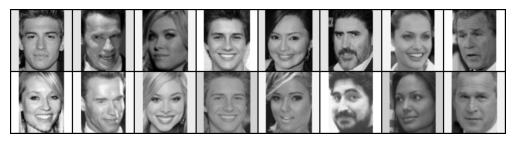

[1. 0. 0. 0. 1. 0. 0. 0.]


In [13]:
transformation = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255)
])

train_ds = ModelDataset(root=TRAIN_DATASET_PATH, transform=transformation)
valid_ds = ModelDataset(root=TEST_DATASET_PATH, transform=transformation)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=get_workers(), pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=get_workers(), pin_memory=True)

ds = ModelDataset(root=TRAIN_DATASET_PATH, transform=transformation)
vis_dataloader = DataLoader(ds, shuffle=True, num_workers=1, batch_size=8)
example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(tv.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = xm.xla_device()

# Example usage
# num_classes = 512  # Number of dimensions in the embedding
# margin = 0.2  # Margin for triplet loss

# Create Siamese network with Inception-ResNet-v2
siamese_network = Net3()

# Create triplet loss criterion
# triplet_loss = nn.TripletMarginLoss(margin=margin)
# triplet_loss = TripletLoss(margin)
criterion = nn.BCEWithLogitsLoss()

# load the saved parameters
if FINE_TUNE:
    state_dict = torch.load(MODEL_PATH, map_location=device)
    siamese_network.load_state_dict(state_dict)  # load the state dictionary into the BCE_and_ContrastiveLoss

# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(siamese_network.parameters(), lr=LEARNING_RATE)   # define the optimizer

scheduler = StepLR(optimizer, step_size=LR_DECAY['step_size'], gamma=LR_DECAY['gamma']) if LR_DECAY['active'] else None # Define the scheduler
# scheduler = ExponentialLR(optimizer, gamma=0.94)
summary(Net3(), input_size=[INPUT_SHAPE, INPUT_SHAPE])
torch.cuda.empty_cache()
train_last(siamese_network, train_loader, valid_loader, optimizer, scheduler, criterion, EPOCHS, checkpoint_interval=2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 222, 222]          36,928
       BatchNorm2d-5         [-1, 64, 222, 222]             128
              ReLU-6         [-1, 64, 222, 222]               0
         MaxPool2d-7         [-1, 64, 111, 111]               0
            Conv2d-8        [-1, 128, 111, 111]          73,856
       BatchNorm2d-9        [-1, 128, 111, 111]             256
             ReLU-10        [-1, 128, 111, 111]               0
           Conv2d-11        [-1, 128, 109, 109]         147,584
      BatchNorm2d-12        [-1, 128, 109, 109]             256
             ReLU-13        [-1, 128, 109, 109]               0
        MaxPool2d-14          [-1, 128,